## Image Captioning
    - Generating Captions for Images

## Steps
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
# from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [5]:
captions = readTextFile("/content/drive/MyDrive/Image_Captioning/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [6]:
print(len(captions))

40460


In [7]:
first, second = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [8]:
# Dictionary to Map each Image with the list of captions it has

In [9]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]

    # if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []

    descriptions[img_name].append(second)

In [10]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
## 3. IC 03 - Text Cleaning

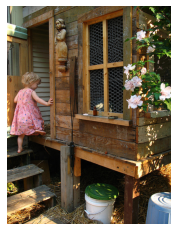

In [14]:
IMG_PATH = "/content/drive/MyDrive/Image_Captioning/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Data Cleaning

In [15]:
# Here we are not stemming, just lowering words, removing puntuation and numbers as we want our model to know about a,the,... and verbs as it gives more actual english sentence feels and understanding

In [16]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()

    sentence = [s for s in sentence if len(s)>1] # remove those has only 1 word length
    sentence = " ".join(sentence)
    return sentence

In [17]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [18]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [19]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [20]:
# Write the data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

## 4. IC 04 - Creating Vocab

In [21]:
 # Vocabulary
 descriptions = None
 with open("descriptions.txt",'r') as f:
     descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [22]:
print(type(descriptions))

<class 'dict'>


In [23]:
# Vocab - unique words from total words

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [24]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in  des.split()]

print("Total Words %d"%len(total_words))

Total Words 373837


In [25]:
# Filter words from the vocab according to certain threshold frequency

In [26]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [27]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [28]:
print(len(total_words))

1845


## 5. IC 05 - Prepare Train Test Data

In [29]:
# Prepare train/test data

In [31]:
train_file_data = readTextFile("/content/drive/MyDrive/Image_Captioning/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/Image_Captioning/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [32]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [33]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [34]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data - as we will use a RNN/LSTM based layer for text generation so it will be helpful to stop as one word output go to another as input 
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [35]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## 6. IC 06 - Image Processing

## Transfer Learning
- Images --> Features
- Text ---> Features

### Step - 1 Image Feature Extraction

In [36]:
# using transfer learning extracting features from images before creating fake data

In [37]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

102981632/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [38]:
model_new = Model(model.input,model.layers[-2].output)
# adding our input from last second layer (avg_pool)

In [39]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) # expanding the dimensions as we can't feed (224,224,3) single image to a model like Resnet so we have to feed it in batch so we change it to [batch,224,224,3] and here batch=1
    # we can use reshape function also

    # Normalisation
    img = preprocess_input(img) # using inbuilt preprocess_input of Resnet50 to normalise the input image according to it
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


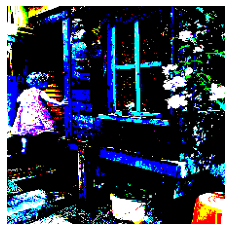

In [41]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

# this is a preprocess image according to Resnet we are not able to see it clear because  of matplotlib

In [42]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    # print(feature_vector.shape)
    return feature_vector

In [43]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535933, 0.1678256 , 0.3251759 , ..., 0.05107147, 0.3282118 ,
       1.004338  ], dtype=float32)

In [44]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)

    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)

end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [45]:
!mkdir saved

In [46]:
# Store everything to the disk
# using pickle as it can dump/load data from ram to rom
# saving because the data is huge so it takes time to do all work again
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [47]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 279.31201791763306


In [48]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## 8. IC 08 - Preprocessing Captions

In [ ]:
## Data preprocessing for Captions

In [49]:
# Vocab
len(total_words)

1845

In [50]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word

# using i=0 for " " as it needs in vocab for giving adding blank spaces in sentences when then sentence gets over

In [51]:
# word_to_idx["dog"]
# idx_to_word[6]
print(len(idx_to_word))

1845


In [52]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [53]:
max_len = 0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len,len(cap.split()))

print(max_len)

35


## 9. IC 09 - Image Captioning as Supervised Learning Problem

In [54]:
# In this get to know how we have to see this image captioning as supervised learning.

# So during training while giving sentence to RNN model we provide ground truth at every next to get a predicted value inspite what ever our model predicted so that it get abled generate. But during testing phase we provide the predicted y value to get to know next word of sentence.

# as every word depend on previous words in sentence it can be wriiten as
# probability of sentence = [P(w1|w0)*P(w2|w0w1)*P(w3|w0w1w2)......]
# and this is P(Wt+1|w1.....wt) known as joint probabbility.

# This whole concept of difference in training and testing time is known Language Model.
# so we need a data generator for our project

## 10. IC 10 - Making Custom Data Loader

### Data Loader (Generator)

In [55]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]

    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1

            photo = encoding_train[key]
            for desc in desc_list:

                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx] # we change all words in sentence to their corresponding no
                for i in range(1,len(seq)):
                    xi = seq[0:i] # taking 0 to i words in each iteration like in first 1(0th word), in second 2(0th+1st word)...
                    yi = seq[i] # y takes only ith word everytime

                    # 0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0] # added padding in post of sentence length by using 0 which is mapped for to use padding. added [0] at last because it give output like [[123]] as there have to be multiple exaples but now we only one so we take it and use it
                    yi = to_categorical([yi],num_classes=vocab_size)[0] # changed yi ith word to one-hot vector

                    X1.append(photo) # 2048 dimensional vector
                    X2.append(xi) # 35 dimensional vector as max length of sentence later we change it into glove vector
                    y.append(yi) # vector = vocab size(1800)

                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y)) # yield keep in mind from until it takes things and next time where it has to start again
                    X1,X2,y = [],[],[] # emptying list again for another batch creation
                    n = 0


# here for a batch size we are collecting data points values by taking multiple images at a time

## 11 IC 11 - Using Glove Embedding [Transfer Learning]

### Word Embeddings

In [ ]:
# Here we are using Transfer Learning for both images and text

# Now before feed to RNN/LSTM we have to use a embedding layer where we can 1. train it as we go, 2. Pre init it like we are using glove vector for it.

# so we are getting a matrix for our embedding with the help of Glove.6B.50d as a size of our vocab and 50dimensionals

In [56]:
f = open("/content/drive/MyDrive/Image_Captioning/saved/glove.6B.200d.txt",encoding='utf8')

In [57]:
embedding_index = {}

for line in f:
    values = line.split()

    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [58]:
f.close()

In [59]:
embedding_index['apple']

array([-0.11359  ,  0.20144  , -0.47074  , -0.028013 ,  0.67625  ,
       -1.0141   , -0.29246  , -0.28873  ,  0.13012  ,  0.31178  ,
       -0.25401  ,  0.57485  , -0.064537 ,  0.39739  ,  0.13192  ,
       -0.23828  , -0.12131  ,  0.12915  ,  0.088295 ,  0.77233  ,
        0.10574  ,  1.1814   , -0.46879  , -0.65922  , -0.52528  ,
        0.10718  , -0.25379  ,  0.25619  , -0.2911   , -0.32413  ,
       -0.57895  , -0.075895 ,  0.22591  ,  0.69913  ,  0.81007  ,
        0.17848  , -0.049312 , -0.17217  , -0.57783  ,  0.56127  ,
       -0.46485  , -0.093234 ,  0.84768  ,  0.2882   , -0.45114  ,
        0.2758   ,  0.39131  , -0.46888  , -0.12888  ,  1.661    ,
       -0.62361  , -0.45564  , -0.065663 , -0.23943  , -0.22448  ,
        0.3533   , -0.80996  ,  0.33755  , -0.033035 ,  0.2907   ,
        0.64122  ,  0.49552  , -0.20464  , -0.19524  ,  0.18013  ,
       -0.71932  , -0.89986  ,  0.53544  ,  0.93706  , -0.039912 ,
        0.86863  ,  0.48379  ,  0.87309  ,  0.029772 , -0.6211

In [60]:
def get_embedding_matrix():
    emb_dim = 200
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [61]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 200)

In [63]:
embedding_matrix[1847] # 1847 - startseq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 12. IC 12 - Caption Bot AI Model

In [64]:
# (Model Architecture) - https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

## 13. IC 13 - Model Implementation(Keras Functional API)

### Model Architecture

In [65]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [66]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=200,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [67]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [68]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 200)      369600      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [69]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix]) # setting our pre initialised embedding matrix to the model
model.layers[2].trainable = False # make it false so no changes occur top it as it is already pre initialised

In [70]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

## 14. IC 14 - Model Training

### Training of Model

In [71]:
epochs = 20
batch_size = 3
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [72]:
def train():

    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [73]:
encoding_train = []
encoding_train = pd.read_pickle('saved/encoded_train_features.pkl')

In [87]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    # model.save('./model_weights/model_'+str(i)+'.h5')


# model is trained on only 10 epochs so do it again for more

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 31s 16ms/step - loss: 2.1389


In [88]:
model.save('./model_weights/model_3iteration.h5')

In [89]:
model = load_model('./model_weights/model_3iteration.h5')

## 15. IC 15 - Prediction/Interfernce

### Predictions

In [90]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Word with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [91]:
encoding_test = []
encoding_test = pd.read_pickle('saved/encoded_test_features.pkl')

dog is playing with fuzzy toy


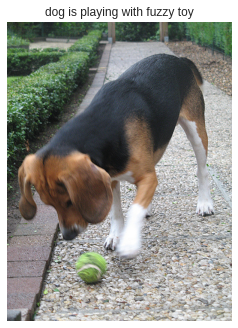

man in yellow shirt is rock climbing


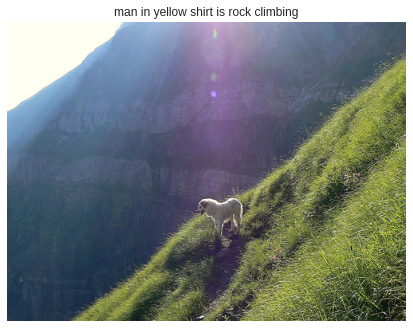

two girls in fancy clothes are sitting on the ground in front of some water


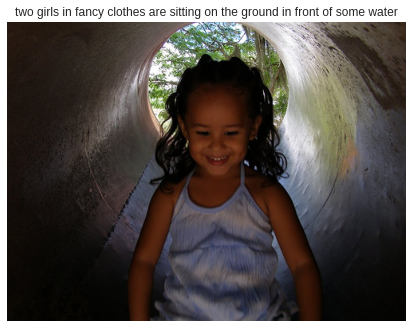

surfer rides the wave


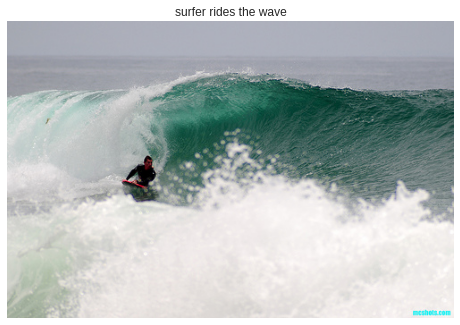

man in swim trunks is splashing water in the sea


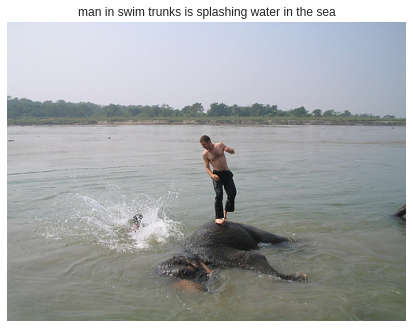

man is climbing rock wall


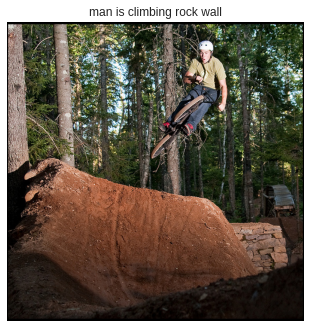

dog jumps over pile of wood


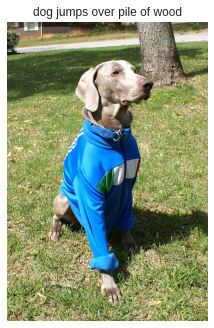

dog chews on toy


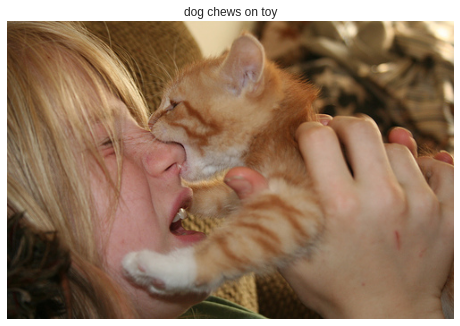

man in blue helmet and blue helmet is jumping his bike over the ground


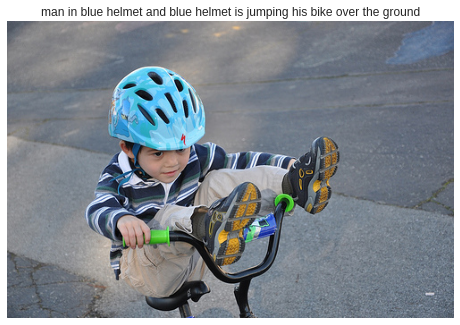

surfer is riding wave


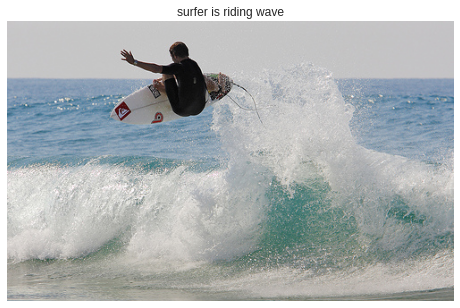

man in headband and cap is playing guitar


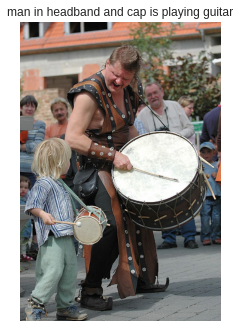

man in hoodie and cast smokes cigarette


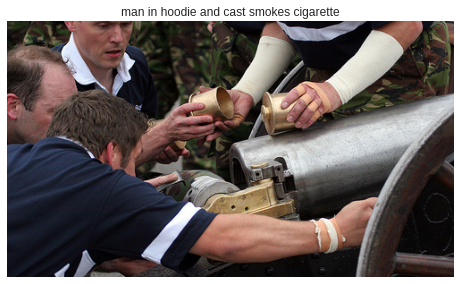

group of people are sitting in row in front of crowd


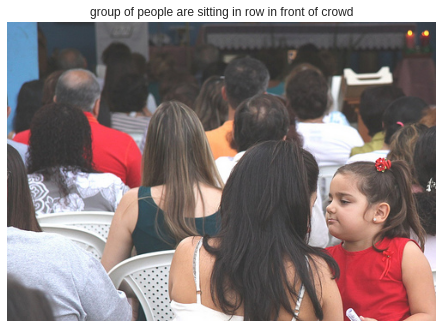

group of motocross racers are jumping over row of dirt


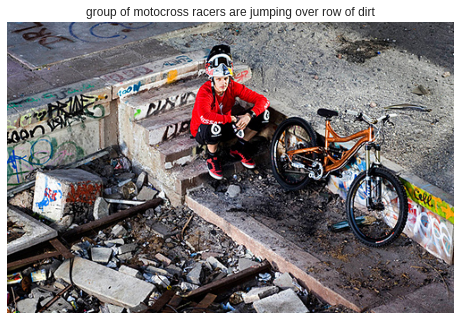

man in yellow shirt and khaki pants is riding bike through the woods


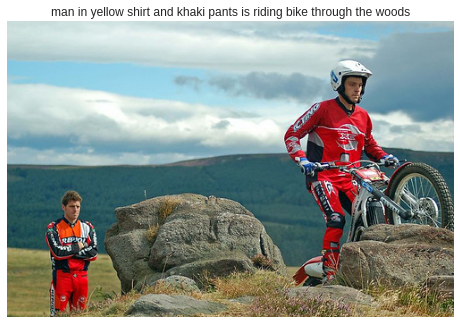

In [92]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))

    i = plt.imread("/content/drive/MyDrive/Image_Captioning/Flickr_Data/Images/"+img_name+".jpg")

    caption = predict_caption(photo_2048)
    print(caption)

    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [80]:
# !zip -r /content/model_weights.zip /content/model_weights
# from google.colab import files
# files.download("/content/model_weights.zip")

  adding: content/model_weights/ (stored 0%)
  adding: content/model_weights/model_3.h5 (deflated 15%)
  adding: content/model_weights/model_4.h5 (deflated 15%)
  adding: content/model_weights/model_10.h5 (deflated 15%)
  adding: content/model_weights/model_5.h5 (deflated 15%)
  adding: content/model_weights/model_2.h5 (deflated 15%)
  adding: content/model_weights/model_0.h5 (deflated 12%)
  adding: content/model_weights/model_14.h5 (deflated 15%)
  adding: content/model_weights/model_19.h5 (deflated 15%)
  adding: content/model_weights/model_13.h5 (deflated 15%)
  adding: content/model_weights/model_8.h5 (deflated 15%)
  adding: content/model_weights/model_12.h5 (deflated 15%)
  adding: content/model_weights/model_15.h5 (deflated 15%)
  adding: content/model_weights/model_6.h5 (deflated 15%)
  adding: content/model_weights/model_16.h5 (deflated 15%)
  adding: content/model_weights/model_17.h5 (deflated 15%)
  adding: content/model_weights/model_11.h5 (deflated 15%)
  adding: content/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>